# Manually inspect the release windows to see why the release free energy is so high...

In [59]:
%load_ext autoreload
%autoreload 2

import os as os
import numpy as np
import glob as glob

import matplotlib.pyplot as plt

import parmed as pmd
import pytraj as pt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


First, let's load in the structure and a test trajectory.

In [60]:
structure = pt.load('full.crds', 'full.hmr.topo')
stripped = structure.strip(':WAT,:Na+,:Cl-')

traj = pt.load('r000/prod.000.nc', top=stripped.topology)

The conformational restraints active during release are given by two sets of 4-atom masks and the six residues in the host.

In [61]:
host_conformational_template = [['O5', 'C1', 'O1', 'C4'],
                                ['C1', 'O1', 'C4', 'C5']
                               ]

host_residues = ['4', '5', '6', '7', '8', '9']

In [62]:
test_dihedrals = [':4@' + i for i in host_conformational_template[0]]

In [63]:
test_timeseries = pt.dihedral(traj, ' '.join(test_dihedrals))

The histogram of one dihedral in one trajectory looks more-or-less normal, about what we'd expect.

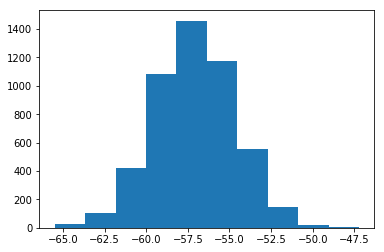

In [64]:
plt.hist(test_timeseries, bins=10);

Now, let's generate a list of all the conformational restraints (two per residue in the host).

In [71]:
all_dihedrals = []
for n in range(4, 10):
    if n + 1 < 10:
        next_residue = n + 1
    else:
        next_residue = 4
    all_dihedrals.append(' '.join(
        [f':{n}@{host_conformational_template[0][0]}',
         f':{n}@{host_conformational_template[0][1]}',
         f':{n}@{host_conformational_template[0][2]}',
         f':{next_residue}@{host_conformational_template[0][3]}'
        ]))
    all_dihedrals.append(' '.join(
        [f':{n}@{host_conformational_template[1][0]}',
         f':{n}@{host_conformational_template[1][1]}',
         f':{next_residue}@{host_conformational_template[1][2]}',
         f':{next_residue}@{host_conformational_template[1][3]}'
        ]))

In [72]:
all_dihedrals

[':4@O5 :4@C1 :4@O1 :5@C4',
 ':4@C1 :4@O1 :5@C4 :5@C5',
 ':5@O5 :5@C1 :5@O1 :6@C4',
 ':5@C1 :5@O1 :6@C4 :6@C5',
 ':6@O5 :6@C1 :6@O1 :7@C4',
 ':6@C1 :6@O1 :7@C4 :7@C5',
 ':7@O5 :7@C1 :7@O1 :8@C4',
 ':7@C1 :7@O1 :8@C4 :8@C5',
 ':8@O5 :8@C1 :8@O1 :9@C4',
 ':8@C1 :8@O1 :9@C4 :9@C5',
 ':9@O5 :9@C1 :9@O1 :4@C4',
 ':9@C1 :9@O1 :4@C4 :4@C5']

For each dihedral, let's look at its histogram in the first release window (`r000`). The restriants are pretty strong, so these should be fairly tight histograms.

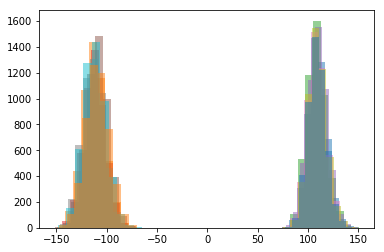

In [73]:
for dihedral in all_dihedrals:
    ts = pt.dihedral(traj, [dihedral])
    plt.hist(ts, bins=10, alpha=0.5);

Next, let's check out the restraints trajectory by trajectory. This turns out not to be very useful.

In [74]:
trajectories = glob.glob('r*/prod.000.nc')

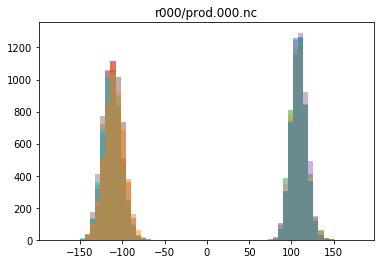

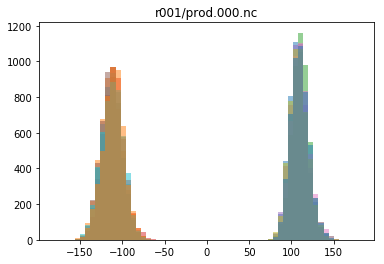

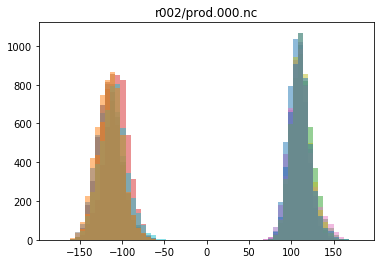

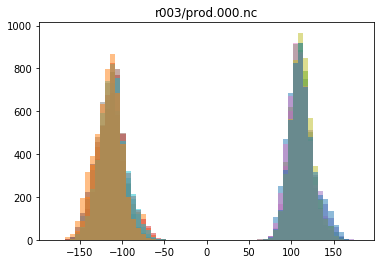

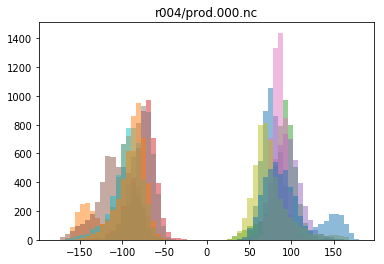

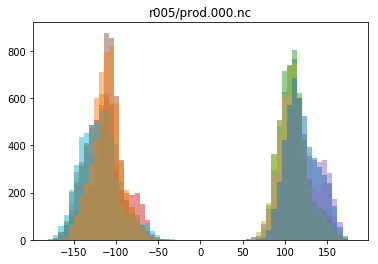

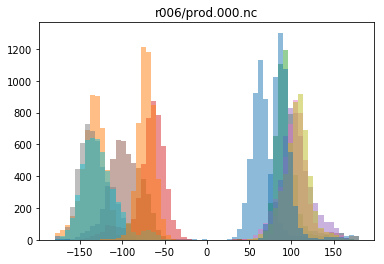

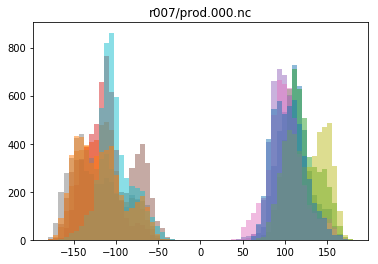

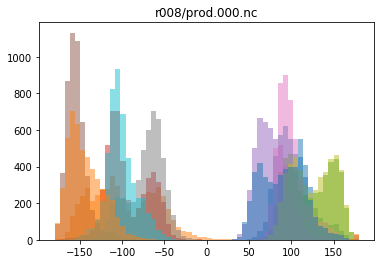

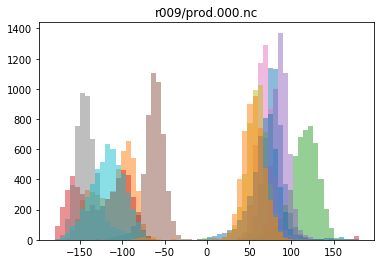

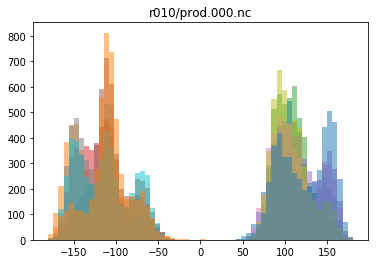

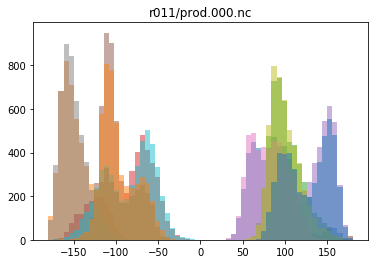

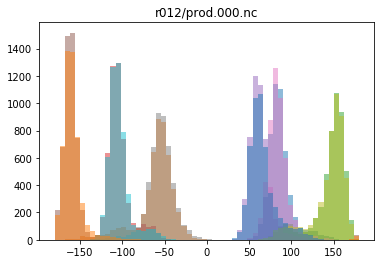

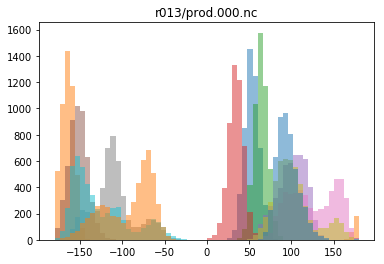

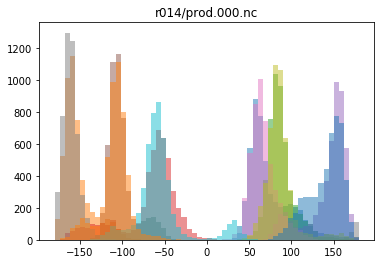

In [75]:
for trajectory in sorted(trajectories):
    plt.figure()
    plt.title(trajectory)
    traj = pt.load(trajectory, top=stripped.topology)
    for dihedral in all_dihedrals:
        ts = pt.dihedral(traj, [dihedral])
        plt.hist(ts, bins=60, alpha=0.5, range=(-180, 180));

It's easier to ask look at each dihedral's histogram across each trajectory instead (the opposite of the last loop). I would have expected these to flatten out as we progressed from `r000` \rightarrow `r014`.

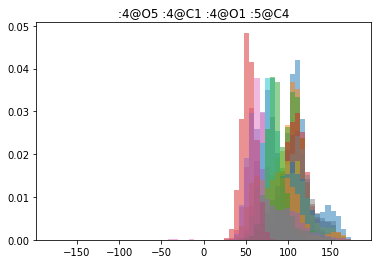

In [76]:
for dihedral in [all_dihedrals[0]]:
    plt.figure()
    plt.title(dihedral)
    for trajectory in sorted(trajectories):
        traj = pt.load(trajectory, top=stripped.topology)
        ts = pt.dihedral(traj, [dihedral])
        plt.hist(ts, bins=60, alpha=0.5, range=(-180, 180), normed=True);

To more clearly see how the dihedral histograms change, I'm plotting them on top of each other. The bottom-most line is `r000` and the top-most line is `r014`. In a few cases, the histograms look flatter or more peaked, but there is no general trend, like going from a well-defined peak to a broader one.

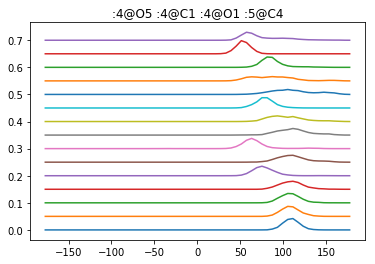

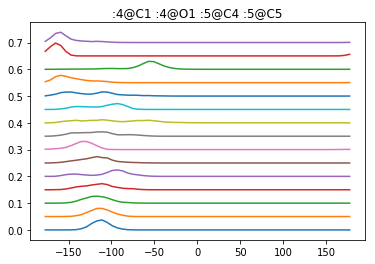

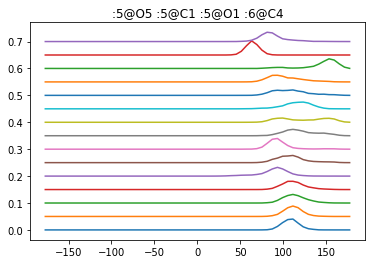

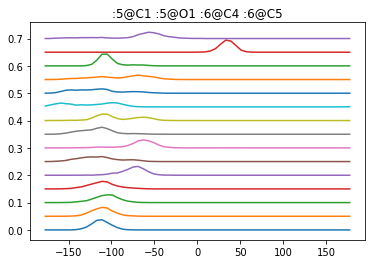

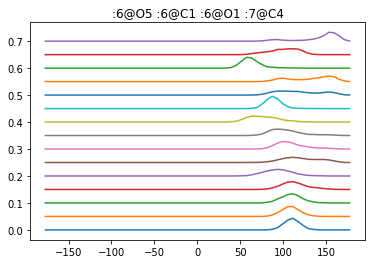

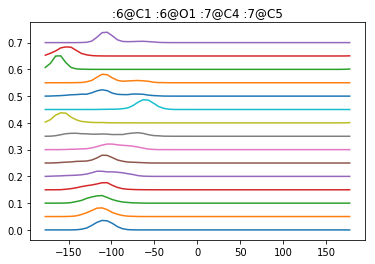

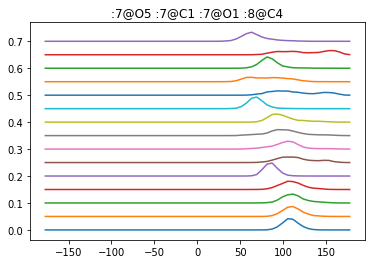

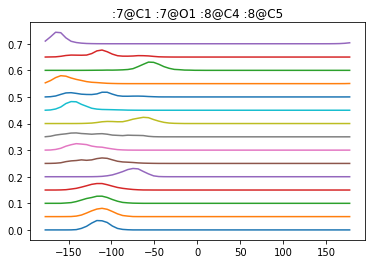

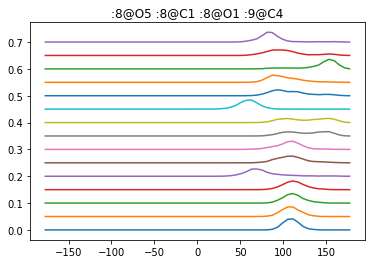

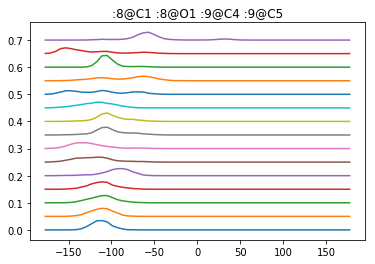

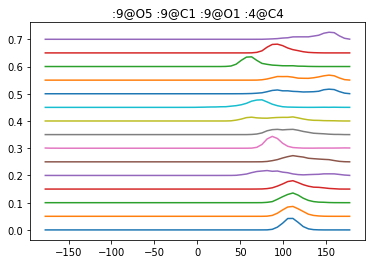

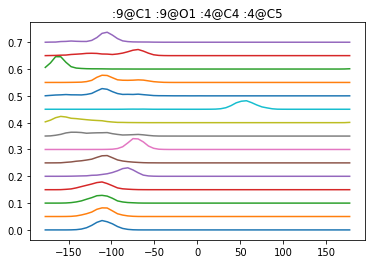

In [79]:
for dihedral in all_dihedrals:
    plt.figure()
    plt.title(dihedral)
    for index, trajectory in enumerate(sorted(trajectories)):
        traj = pt.load(trajectory, top=stripped.topology)
        ts = pt.dihedral(traj, [dihedral])
        counts, bin_edges = np.histogram(ts, bins=60, range=(-180, 180), normed=True)
        mids = bin_edges[0:-1] + (bin_edges[1] - bin_edges[0]) / 2
        plt.plot(mids, counts + index*0.05);

Now let's calculate the energy of each restraint in each window, dU/dlambda. This should be the curve that gets integrated to find the total release energy. These curves are all over the place -- not good.

:4@O5 :4@C1 :4@O1 :5@C4 r000/prod.000.nc 667.250166346
:4@O5 :4@C1 :4@O1 :5@C4 r001/prod.000.nc 805.753356322
:4@O5 :4@C1 :4@O1 :5@C4 r002/prod.000.nc 878.598874235
:4@O5 :4@C1 :4@O1 :5@C4 r003/prod.000.nc 1310.03911891
:4@O5 :4@C1 :4@O1 :5@C4 r004/prod.000.nc 5382.15685423
:4@O5 :4@C1 :4@O1 :5@C4 r005/prod.000.nc 2141.69573474
:4@O5 :4@C1 :4@O1 :5@C4 r006/prod.000.nc 10817.8972175
:4@O5 :4@C1 :4@O1 :5@C4 r007/prod.000.nc 2534.82196592
:4@O5 :4@C1 :4@O1 :5@C4 r008/prod.000.nc 2576.00041538
:4@O5 :4@C1 :4@O1 :5@C4 r009/prod.000.nc 4634.93673771
:4@O5 :4@C1 :4@O1 :5@C4 r010/prod.000.nc 4060.25552451
:4@O5 :4@C1 :4@O1 :5@C4 r011/prod.000.nc 5687.10087777
:4@O5 :4@C1 :4@O1 :5@C4 r012/prod.000.nc 3079.67092253
:4@O5 :4@C1 :4@O1 :5@C4 r013/prod.000.nc 16049.4098349
:4@O5 :4@C1 :4@O1 :5@C4 r014/prod.000.nc 8965.14414884
:4@C1 :4@O1 :5@C4 :5@C5 r000/prod.000.nc 790.441923843
:4@C1 :4@O1 :5@C4 :5@C5 r001/prod.000.nc 1089.00872033
:4@C1 :4@O1 :5@C4 :5@C5 r002/prod.000.nc 1710.79150779
:4@C1 :4@O

:9@O5 :9@C1 :9@O1 :4@C4 r000/prod.000.nc 600.529831916
:9@O5 :9@C1 :9@O1 :4@C4 r001/prod.000.nc 904.237115196
:9@O5 :9@C1 :9@O1 :4@C4 r002/prod.000.nc 1145.07572129
:9@O5 :9@C1 :9@O1 :4@C4 r003/prod.000.nc 1971.97458862
:9@O5 :9@C1 :9@O1 :4@C4 r004/prod.000.nc 6128.39935203
:9@O5 :9@C1 :9@O1 :4@C4 r005/prod.000.nc 3785.53057815
:9@O5 :9@C1 :9@O1 :4@C4 r006/prod.000.nc 5352.91221417
:9@O5 :9@C1 :9@O1 :4@C4 r007/prod.000.nc 2182.76177589
:9@O5 :9@C1 :9@O1 :4@C4 r008/prod.000.nc 5061.21821142
:9@O5 :9@C1 :9@O1 :4@C4 r009/prod.000.nc 10137.7288623
:9@O5 :9@C1 :9@O1 :4@C4 r010/prod.000.nc 7193.47350352
:9@O5 :9@C1 :9@O1 :4@C4 r011/prod.000.nc 7169.2629687
:9@O5 :9@C1 :9@O1 :4@C4 r012/prod.000.nc 10389.0093331
:9@O5 :9@C1 :9@O1 :4@C4 r013/prod.000.nc 1464.62901354
:9@O5 :9@C1 :9@O1 :4@C4 r014/prod.000.nc 10355.8849078
:9@C1 :9@O1 :4@C4 :4@C5 r000/prod.000.nc 812.666415578
:9@C1 :9@O1 :4@C4 :4@C5 r001/prod.000.nc 974.893080325
:9@C1 :9@O1 :4@C4 :4@C5 r002/prod.000.nc 1285.38986658
:9@C1 :9@O1

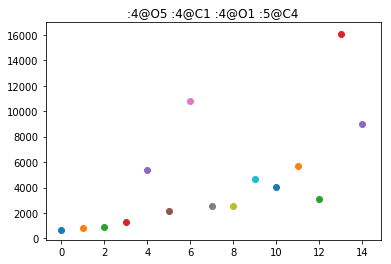

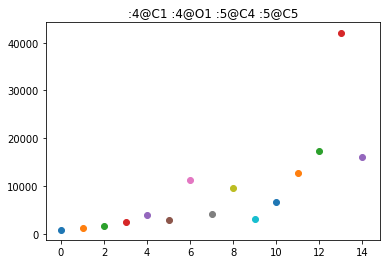

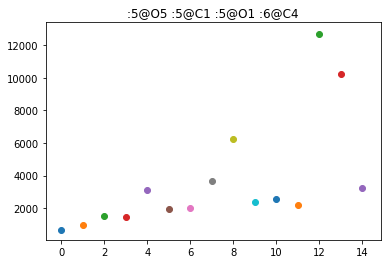

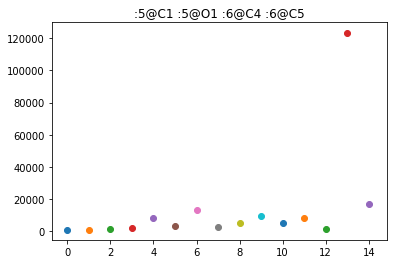

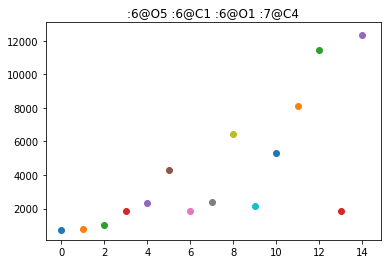

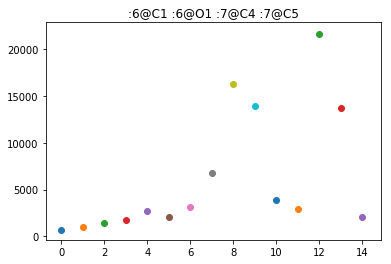

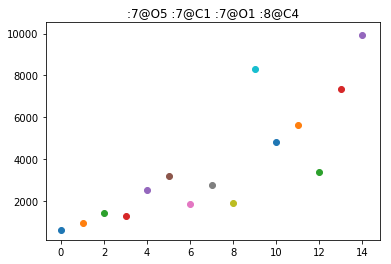

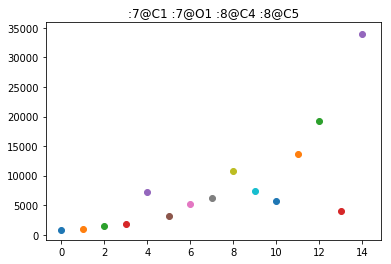

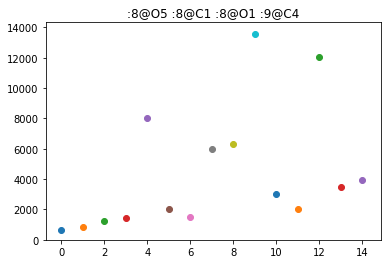

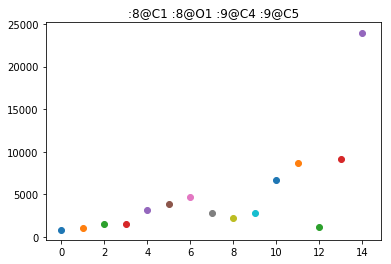

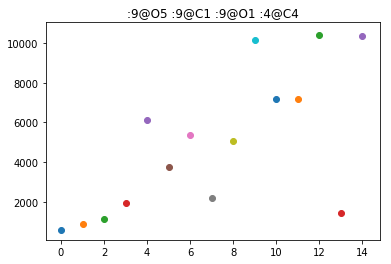

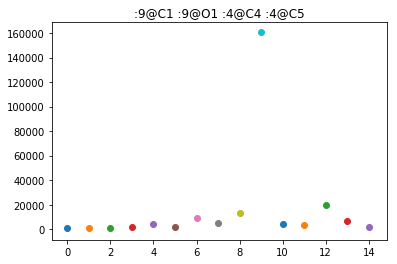

In [80]:
fc_max = 6.0
targets = [104.3, -108.8]

for dihedral in all_dihedrals:
    plt.figure()
    plt.title(dihedral)
    if 'O5' in dihedral:
        target = 104.3
    elif 'C5' in dihedral:
        target = -108.8
    for index, trajectory in enumerate(sorted(trajectories)):
        traj = pt.load(trajectory, top=stripped.topology)
        ts = pt.dihedral(traj, [dihedral])
        dUdlambda = fc_max*(ts - target)**2
        # print(dihedral, trajectory, np.mean(dUdlambda))
        plt.scatter(index, np.mean(dUdlambda))

In [130]:
# Computing restraint forces and uncertainty
# k     x val      mean  Std. Dev       SEM
fc_max = 6.0
targets = [104.3, -108.8]
lambdas = np.linspace(1, 0, 15)

for dihedral in all_dihedrals:
    if 'O5' in dihedral:
        target = 104.3
    elif 'C5' in dihedral:
        target = -108.8
    print(f'{"k":5s} {"lambda":8s} {"mean":7s} {"Std. Dev":9s} {"SEM":9s}')
    for index, trajectory in enumerate(sorted(trajectories)):
        traj = pt.load(trajectory, top=stripped.topology)
        ts = pt.dihedral(traj, [dihedral])
        dUdlambda = fc_max*(ts - target)**2
        print(f'{str(index):5s} {lambdas[index]:0.2f} {np.mean(dUdlambda):>9.2f} {np.std(dUdlambda):>9.2f}' +
              f'{np.std(dUdlambda)/np.sqrt(len(dUdlambda)):>9.2f}')


k     lambda   mean    Std. Dev  SEM      
0     1.00    667.25    996.34    14.09
1     0.93    805.75   1243.79    17.59
2     0.86    878.60   1446.78    20.46
3     0.79   1310.04   2133.24    30.17
4     0.71   5382.16   3821.84    54.05
5     0.64   2141.70   3586.68    50.72
6     0.57  10817.90   9036.76   127.80
7     0.50   2534.82   3989.45    56.42
8     0.43   2576.00   3700.85    52.34
9     0.36   4634.94   3421.00    48.38
10    0.29   4060.26   5402.45    76.40
11    0.21   5687.10   6092.27    86.16
12    0.14   3079.67   2573.49    36.39
13    0.07  16049.41   5026.45    71.08
14    0.00   8965.14   6467.52    91.46
k     lambda   mean    Std. Dev  SEM      
0     1.00    790.44   1091.82    15.44
1     0.93   1089.01   1482.77    20.97
2     0.86   1710.79   2195.80    31.05
3     0.79   2444.30   3109.76    43.98
4     0.71   3865.89   4065.96    57.50
5     0.64   2794.43   3783.75    53.51
6     0.57  11144.76  53256.62   753.16
7     0.50   4157.88   4634.27    

In [134]:
# Computing restraint forces and uncertainty
# k     x val      mean  Std. Dev       SEM
fc_max = 6.0
targets = [104.3, -108.8]
lambdas = np.linspace(1, 0, 15)

print(f'{"k":5s} {"lambda":8s} {"mean":7s} {"Std. Dev":9s} {"SEM":9s}')        
for index, trajectory in enumerate(sorted(trajectories)):
    traj = pt.load(trajectory, top=stripped.topology)
    dUdlambdas = []
    N_ks = []
    for dihedral in all_dihedrals:
        if 'O5' in dihedral:
            target = 104.3
        elif 'C5' in dihedral:
            target = -108.8
        ts = pt.dihedral(traj, [dihedral])
        dUdlambda = fc_max*(ts - target)**2
        dUdlambdas.append(dUdlambda)
        N_ks.append(len(ts))
        
    print(f'{str(index):5s} {lambdas[index]:0.2f} {np.mean(dUdlambdas):>9.2f} {np.std(dUdlambdas):>9.2f}' +
              f'{np.std(dUdlambdas)/np.sqrt(np.sum(N_ks)):>9.2f}')




k     lambda   mean    Std. Dev  SEM      
0     1.00    721.98   1040.86     4.25
1     0.93    952.68   1409.31     5.75
2     0.86   1340.04   2035.85     8.31
3     0.79   1679.03   2572.80    10.50
4     0.71   4716.61   5614.09    22.92
5     0.64   2889.03   4210.38    17.19
6     0.57   5815.04  19917.92    81.31
7     0.50   3959.28   6404.04    26.14
8     0.43   7161.88  17887.64    73.03
9     0.36  19855.20  45163.18   184.38
10    0.29   4971.76   9733.62    39.74
11    0.21   6717.14  14767.86    60.29
12    0.14  11107.32  20206.69    82.49
13    0.07  19958.28  45488.99   185.71
14    0.00  11953.60  30862.96   126.00


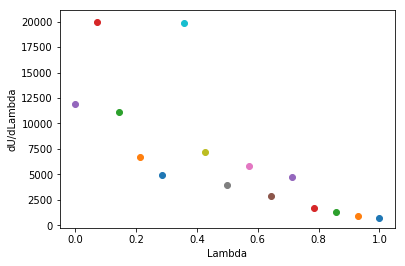

In [141]:
# Computing restraint forces and uncertainty
# k     x val      mean  Std. Dev       SEM
fc_max = 6.0
targets = [104.3, -108.8]
lambdas = np.linspace(1, 0, 15)

plt.figure()

for index, trajectory in enumerate(sorted(trajectories)):
    traj = pt.load(trajectory, top=stripped.topology)
    dUdlambdas = []
    N_ks = []
    for dihedral in all_dihedrals:
        if 'O5' in dihedral:
            target = 104.3
        elif 'C5' in dihedral:
            target = -108.8
        ts = pt.dihedral(traj, [dihedral])
        dUdlambda = fc_max*(ts - target)**2
        dUdlambdas.append(dUdlambda)
        N_ks.append(len(ts))
        
    
    plt.errorbar(lambdas[index], np.mean(dUdlambdas), yerr=np.std(dUdlambdas)/np.sqrt(np.sum(N_ks)), fmt='o')
plt.xlabel('Lambda')
plt.ylabel('dU/dLambda')



Let's re-run `r009` and a few others.

Use the visualization scrip to render the restrainst to make sure they are what we expect for jacks.

In [144]:
import nglview as nv

In [194]:
traj = pt.load('/Users/dslochower/Desktop/release/r000/prod.000.nc', top=stripped.topology)

In [195]:
view = nv.show_pytraj(traj)

In [196]:
view.representations = []

In [197]:
view.add_representation('cartoon')

In [202]:
view = traj.view()

In [203]:
view

NGLWidget(count=5000)